# Synthesize Multiple Tables (HMA)

In this notebook, we'll the SDV library to create synthetic data for multiple, connected tables and evaluate it. The SDV uses machine learning to learn patterns from real data and emulates them when creating synthetic data.

We'll use the Heirarchical ML algorithm (**HMA**) to do this. HMA is a customizable and transparent way to synthesize multi-table data.

In [1]:
from sdv.datasets.demo import download_demo
from sdv.multi_table import HMASynthesizer
from sdv.evaluation.multi_table import get_column_plot, get_column_pair_plot

In [2]:
real_data, metadata = download_demo(
    modality='multi_table',
    dataset_name='fake_hotels'
)

**Details**: The dataset is available in two tables.

- The `hotels` table describes some stats about each hotel. The column `hotel_id` is a _primary key_ that uniquely identifies every hotel.
- The `guests` table describes the guests that are staying at each hotel. The column `hotel_id` in this table is a _foreign key_ that refers to the `hotels` table.

In [3]:
real_data['hotels'].head(3)

,hotel_id,city,state,rating,classification
0,HID_000,Boston,Massachusetts,4.8,RESORT
1,HID_001,Boston,Massachuesetts,4.1,CHAIN
2,HID_002,San Francisco,California,3.8,MOTEL


In [4]:
real_data['guests'].head(3)

,guest_email,hotel_id,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,awolf@phillips.com,HID_000,False,BASIC,37.89,27 Dec 2020,28 Dec 2020,156.23,"993 Rebecca Landing\nJesseburgh, PA 05072",4075084747483975747
1,tonya44@wilkinson-wilkins.com,HID_000,False,BASIC,24.37,30 Dec 2020,31 Dec 2020,139.43,"958 Beverly Bypass\nSouth Ronald, GA 46368",180072822063468
2,harriskathleen@goodwin.com,HID_000,True,DELUXE,0.00,17 Sep 2020,19 Sep 2020,403.33,"8302 Nathaniel Pike\nRileyland, TX 71613",38983476971380


In [5]:
metadata

{
    "tables": {
        "guests": {
            "columns": {
                "guest_email": {
                    "sdtype": "email",
                    "pii": true
                },
                "hotel_id": {
                    "sdtype": "id",
                    "regex_format": "[A-Za-z]{5}"
                },
                "has_rewards": {
                    "sdtype": "boolean"
                },
                "room_type": {
                    "sdtype": "categorical"
                },
                "amenities_fee": {
                    "sdtype": "numerical",
                    "computer_representation": "Float"
                },
                "checkin_date": {
                    "sdtype": "datetime",
                    "datetime_format": "%d %b %Y"
                },
                "checkout_date": {
                    "sdtype": "datetime",
                    "datetime_format": "%d %b %Y"
                },
                "room_rate": {
                   

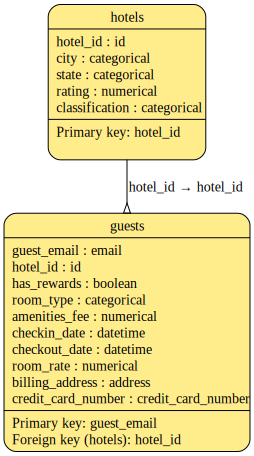

In [6]:
### NOTE: THIS CELL WILL EROR IF YOU DO NOT HAVE GRAPHVIZ INSTALLED 
# Installation instructions - https://graphviz.org/download/
# If you don't want to install graphviz, you can skip this cell, it is not necessary for the rest of the notebook
metadata.visualize()

# 2. Basic Usage

## 2.1 Creating a Synthesizer

An SDV **synthesizer** is an object that you can use to create synthetic data. It learns patterns from the real data and replicates them to generate synthetic data.

In [7]:
synthesizer = HMASynthesizer(metadata)
synthesizer.fit(real_data)

Preprocess Tables: 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]



Learning relationships:


(1/1) Tables 'hotels' and 'guests' ('hotel_id'): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Modeling Tables: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


Now the synthesizer is ready to use!

## 2.2 Generating Synthetic Data

Use the `sample` function. We can pass in a value to `scale` the size of the original dataset. For example, passing in `scale=2` create twice as many hotels and guests as the original data contained.

In [8]:
synthetic_data = synthesizer.sample(scale=2)

The result is a dictionary with keys `'hotels'` and `'guests'` that map to the synthetic data for each table.

In [9]:
synthetic_data['hotels'].head(3)

,hotel_id,city,state,rating,classification
0,HID_000,San Francisco,New York,4.2,CHAIN
1,HID_001,San Francisco,New York,4.3,CHAIN
2,HID_002,Austin,Texas,4.0,CHAIN


In [10]:
synthetic_data['guests'].head(3)

,guest_email,hotel_id,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,moodyeric@example.net,HID_000,False,BASIC,46.64,26 Sep 2020,09 Sep 2020,197.31,"PSC 4273, Box 0888\nAPO AA 28423",5161033759518983
1,coryguzman@example.com,HID_000,False,DELUXE,4.34,03 Jul 2020,13 Jul 2020,202.10,"417 Lawrence Hollow\nEast Ericshire, NM 88906",4133047413145475690
2,caitlinlee@example.net,HID_000,False,BASIC,12.02,28 Nov 2020,29 Oct 2020,197.57,"69754 Mcguire Haven Apt. 260\nCrawfordside, RI...",4977328103788


The synthesizer is generating synthetic guests in the **same format as the original data**. It is also generating **connections between the tables** that make sense.

## 2.3 Anonymization

In the original dataset, we had some sensitive columns such as the guest's email, billing address and phone number. In the synthetic data, these columns are **fully anonymized** -- they contain fake values that follow the format of the original.

In [11]:
sensitive_columns = ['guest_email', 'billing_address', 'credit_card_number']
real_data['guests'][sensitive_columns].head()

,guest_email,billing_address,credit_card_number
0,awolf@phillips.com,"993 Rebecca Landing\nJesseburgh, PA 05072",4075084747483975747
1,tonya44@wilkinson-wilkins.com,"958 Beverly Bypass\nSouth Ronald, GA 46368",180072822063468
2,harriskathleen@goodwin.com,"8302 Nathaniel Pike\nRileyland, TX 71613",38983476971380
3,kayladiaz@wallace-simmons.com,"77 Massachusetts Ave\nCambridge, MA 02139",4969551998845740
4,paigemendoza@tran-martin.com,"1234 Corporate Drive\nBoston, MA 02116",3558512986488983


In [12]:
synthetic_data['guests'][sensitive_columns].head()

,guest_email,billing_address,credit_card_number
0,moodyeric@example.net,"PSC 4273, Box 0888\nAPO AA 28423",5161033759518983
1,coryguzman@example.com,"417 Lawrence Hollow\nEast Ericshire, NM 88906",4133047413145475690
2,caitlinlee@example.net,"69754 Mcguire Haven Apt. 260\nCrawfordside, RI...",4977328103788
3,andreasmith@example.net,"402 Joy Overpass Suite 974\nJoview, WV 75960",3524946844839485
4,fostermichael@example.com,"545 Brown Via\nTeresaport, TX 36995",4446905799576890978


## 2.3 Evaluating Real vs. Synthetic Data
The synthetic data replicates the **mathematical properties** of the real data. To get more insight, we can use the `evaluation` module.

In [13]:
from sdv.evaluation.multi_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata,
    verbose=False
)

The report allows us to visualize the different properties that were captured. For example, the visualization below shows us _which_ individual column shapes were well-captured and which weren't.

In [14]:
fig = quality_report.get_visualization('Column Shapes', table_name='guests')
fig.show()

## 2.4 Visualizing the Data
For more insights, we can visualize the real vs. synthetic data.

Let's perform a 1D visualization comparing a column of the real data to the synthetic data.

In [15]:
for column in real_data["guests"].columns:
    try:
        fig = get_column_plot(
            real_data=real_data,
            synthetic_data=synthetic_data,
            column_name=column,
            table_name='guests',
            metadata=metadata
        )

        fig.show()
    except:
        pass

We can also visualize in 2D, comparing the correlations of a pair of columns.

In [16]:
fig = get_column_pair_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_names=['room_rate', 'room_type'],
    table_name='guests',
    metadata=metadata
)

fig.show()

## 2.5 Saving and Loading
We can save the synthesizer to share with others and sample more synthetic data in the future.

In [17]:
# save_path = "hma_synthesizer.pkl"
# synthesizer.save(save_path)

# synthesizer = HMASynthesizer.load(save_path)

# 3. HMA Customization

A key benefit of using the HMA is **customization and transparency**. This synthesizer uses classical statistics to estimate the shape of every column using a 1D distribution. We can set these shapes ourselves.

In [18]:
custom_synthesizer = HMASynthesizer(
    metadata,
    verbose=False
)

custom_synthesizer.set_table_parameters(
    table_name='hotels',
    table_parameters={
        'default_distribution': 'truncnorm'
    }
)

custom_synthesizer.fit(real_data)

/Users/ryan/github/sdv/venv/lib/python3.10/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning:

invalid value encountered in scalar divide

/Users/ryan/github/sdv/venv/lib/python3.10/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/ryan/github/sdv/venv/lib/python3.10/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



After training, we can inspect the distributions. In this case, the synthesizer returns the parameter it learned using the truncnorm distribution.

<font color=navy><i>More information about truncnorm distribution is available in the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html).</i></font>

In [19]:
learned_distributions = custom_synthesizer.get_learned_distributions(table_name='hotels')
learned_distributions['rating']

{'distribution': 'truncnorm',
 'learned_parameters': {'a': -0.4166664183140626,
  'b': 0.4166667494508458,
  'loc': 4.299999761581422,
  'scale': 1.4400005722046472}}

In [20]:
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html

By setting these distributions strategically, you can make tradeoffs in the quality of your synthetic data.